In [12]:
!pip install mne

In [45]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D, Input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"MNE-Python version: {mne.__version__}")

MNE-Python version: 1.10.2


EDA (Data)

In [3]:
subject_id = 1
runs = [5, 9, 13]

fnames = mne.datasets.eegbci.load_data(subject_id, runs)

raws = [mne.io.read_raw_edf(f, preload=True) for f in fnames]
raw = mne.io.concatenate_raws(raws)

print("Data berhasil dimuat dan digabung.")

Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 06s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
EDF file detected
Setting channel 

In [4]:
print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


In [6]:
sampling_rate = raw.info['sfreq']
n_channels = raw.info['nchan']
channel_names = raw.info['ch_names']

print(f"--- Informasi Struktur Data ---")
print(f"1. Sampling Rate: {sampling_rate} Hz")
print(f"2. Jumlah Channel: {n_channels}")
print(f"3. Daftar Nama Channel (contoh 5 pertama): {channel_names[:5]}")
print(f"4. Format Data Mentah: Data dimuat dari file .edf")
print(f"   Total Durasi Data: {raw.times.max():.2f} detik")

--- Informasi Struktur Data ---
1. Sampling Rate: 160.0 Hz
2. Jumlah Channel: 64
3. Daftar Nama Channel (contoh 5 pertama): ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.']
4. Format Data Mentah: Data dimuat dari file .edf
   Total Durasi Data: 374.99 detik


Using matplotlib as 2D backend.


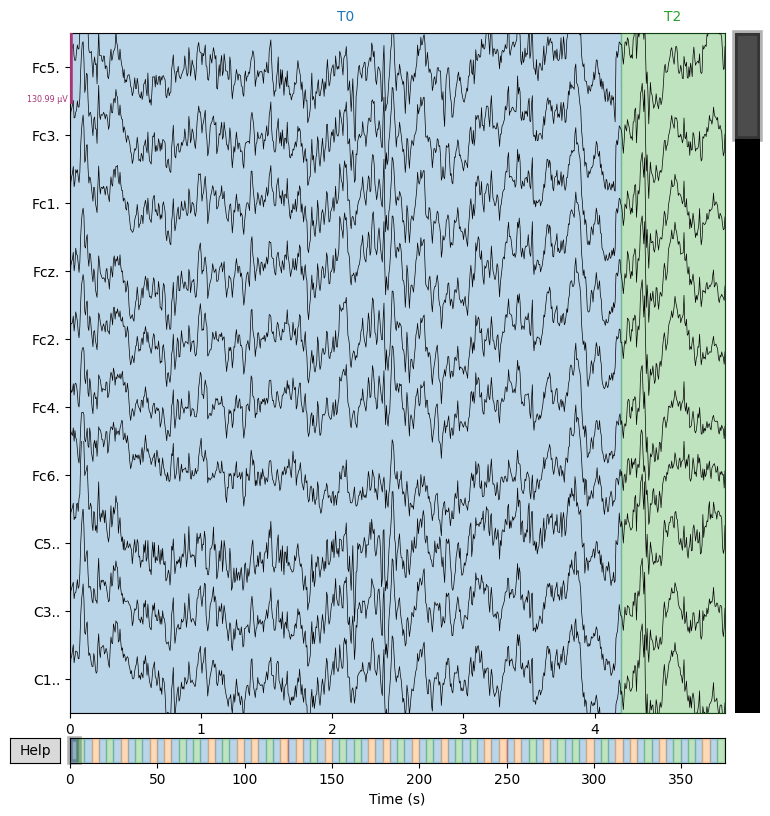

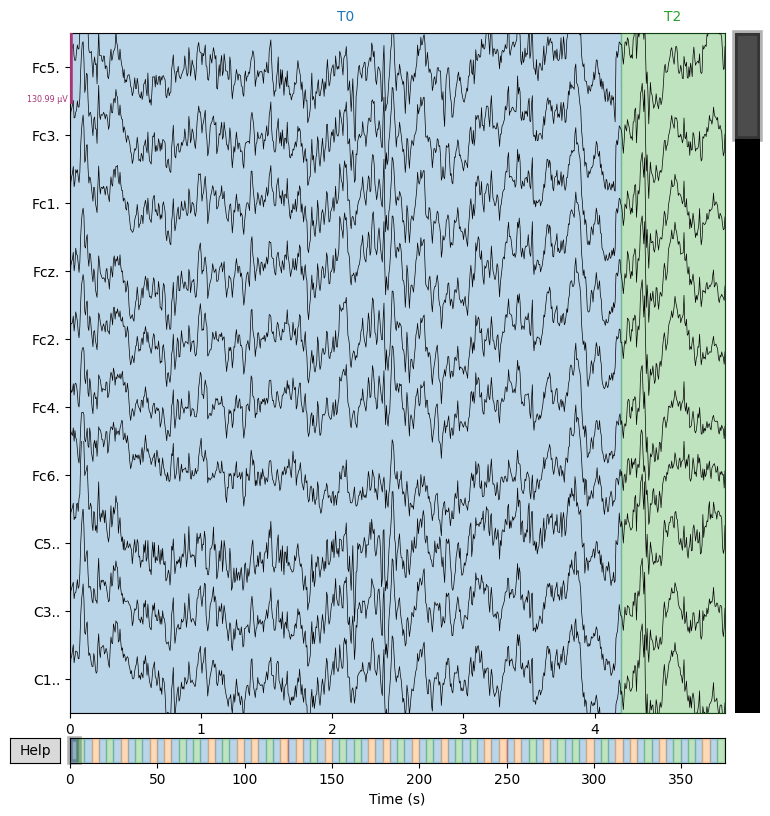

In [7]:
raw.plot(duration=5, n_channels=10, scalings='auto', title='Contoh Sinyal EEG Mentah')

In [8]:
events, event_id = mne.events_from_annotations(raw)

print("--- Informasi Label (Events) ---")
print("Event ID (Label ke Angka):")
print(event_id)

print(f"\nTotal events ditemukan: {len(events)}")
print("Bentuk array events (sample_index, 0, event_code):")
print(events[:5])

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
--- Informasi Label (Events) ---
Event ID (Label ke Angka):
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}

Total events ditemukan: 90
Bentuk array events (sample_index, 0, event_code):
[[   0    0    1]
 [ 672    0    3]
 [1328    0    1]
 [2000    0    2]
 [2656    0    1]]


In [10]:
event_codes = events[:, 2]

event_counts = Counter(event_codes)

labels_map = {v: k for k, v in event_id.items()}

print("\n--- Distribusi Label Kelas ---")
for code, count in event_counts.items():
    if code in labels_map:
        print(f"Label: {labels_map[code]} (Kode: {code}) \t-> Jumlah Trials: {count}")


--- Distribusi Label Kelas ---
Label: T0 (Kode: 1) 	-> Jumlah Trials: 45
Label: T2 (Kode: 3) 	-> Jumlah Trials: 22
Label: T1 (Kode: 2) 	-> Jumlah Trials: 23


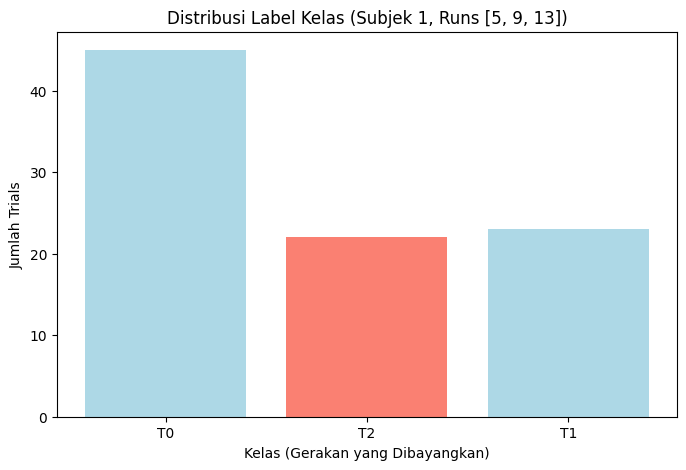

In [11]:
labels = [labels_map[code] for code, count in event_counts.items() if code in labels_map]
counts = [count for code, count in event_counts.items() if code in labels_map]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['lightblue', 'salmon'])
plt.title(f'Distribusi Label Kelas (Subjek {subject_id}, Runs {runs})')
plt.xlabel('Kelas (Gerakan yang Dibayangkan)')
plt.ylabel('Jumlah Trials')
plt.show()

EDA (dataset)

In [135]:
subjects_to_check = range(1, 16)

runs = [5, 9, 13]

all_subject_data = []

print(f"Akan memulai inspeksi untuk {len(list(subjects_to_check))} subjek...")

Akan memulai inspeksi untuk 15 subjek...


In [136]:
warnings.filterwarnings('ignore')

for sub_id in subjects_to_check:
    print(f"\nMemproses Subjek {sub_id}...")

    try:
        fnames = mne.datasets.eegbci.load_data(sub_id, runs)
        raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f) for f in fnames])

        sfreq = raw.info['sfreq']
        n_channels = raw.info['nchan']

        events, event_map = mne.events_from_annotations(raw)

        counts = Counter(events[:, 2])
        t1_count = counts.get(event_map.get('T1', 99), 0) # 99 adlh key 'error'
        t2_count = counts.get(event_map.get('T2', 98), 0)

        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': sfreq,
            'Jml Channel': n_channels,
            'Trials T1 (Tangan)': t1_count,
            'Trials T2 (Kaki)': t2_count,
            'Status': 'OK'
        })

    except Exception as e:
        print(f"GAGAL memproses Subjek {sub_id}. Error: {e}")
        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': 'N/A',
            'Jml Channel': 'N/A',
            'Trials T1 (Tangan)': 'N/A',
            'Trials T2 (Kaki)': 'N/A',
            'Status': 'Error'
        })

print("\n--- Inspeksi Selesai ---")


Memproses Subjek 1...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 2...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R09.edf...
EDF file detected
Setting chan

In [137]:
df_results = pd.DataFrame(all_subject_data).set_index('Subjek')

print("Tabel Ringkasan EDA untuk Subjek 1-15:")
display(df_results)

Tabel Ringkasan EDA untuk Subjek 1-15:


,Sampling Rate,Jml Channel,Trials T1 (Tangan),Trials T2 (Kaki),Status
Subjek,,,,,
1,160.0,64,23,22,OK
2,160.0,64,21,24,OK
3,160.0,64,22,23,OK
4,160.0,64,22,23,OK
5,160.0,64,22,23,OK
6,160.0,64,22,23,OK
7,160.0,64,22,23,OK
8,160.0,64,22,23,OK
9,160.0,64,23,22,OK


In [138]:
print("\n--- Analisis Konsistensi Data ---")

ok_subjects = df_results[df_results['Status'] == 'OK']

if not ok_subjects.empty:
    sfreq_konsisten = ok_subjects['Sampling Rate'].nunique() == 1
    sfreq_value = ok_subjects['Sampling Rate'].iloc[0]
    print(f"1. Sampling Rate: {'KONSISTEN' if sfreq_konsisten else 'TIDAK KONSISTEN'}")
    if sfreq_konsisten:
        print(f"   -> Semua subjek memiliki {sfreq_value} Hz.")

    ch_konsisten = ok_subjects['Jml Channel'].nunique() == 1
    ch_value = ok_subjects['Jml Channel'].iloc[0]
    print(f"2. Jml Channel:   {'KONSISTEN' if ch_konsisten else 'TIDAK KONSISTEN'}")
    if ch_konsisten:
        print(f"   -> Semua subjek memiliki {ch_value} channels.")

    ok_subjects['Imbalance'] = abs(ok_subjects['Trials T1 (Tangan)'] - ok_subjects['Trials T2 (Kaki)'])
    avg_imbalance = ok_subjects['Imbalance'].mean()
    print(f"3. Keseimbangan Label:")
    print(f"   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: {avg_imbalance:.2f} trials")
    print(f"   -> Subjek dengan imbalance > 2 trials:\n {ok_subjects[ok_subjects['Imbalance'] > 2][['Imbalance']]}")

else:
    print("Tidak ada data subjek yang berhasil diproses.")


--- Analisis Konsistensi Data ---
1. Sampling Rate: KONSISTEN
   -> Semua subjek memiliki 160.0 Hz.
2. Jml Channel:   KONSISTEN
   -> Semua subjek memiliki 64 channels.
3. Keseimbangan Label:
   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: 1.40 trials
   -> Subjek dengan imbalance > 2 trials:
         Imbalance
Subjek           
2               3
13              3
14              3



--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---


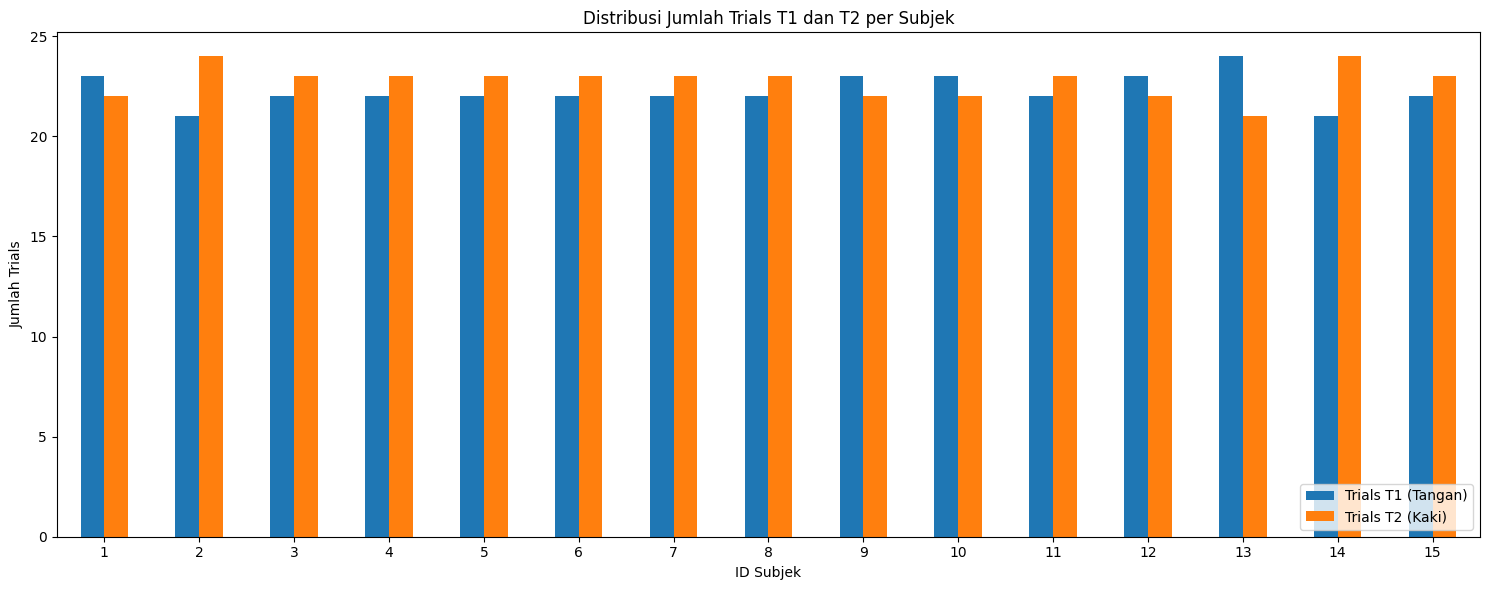

In [139]:
print("\n--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---")

if not ok_subjects.empty:
    ax = ok_subjects[['Trials T1 (Tangan)', 'Trials T2 (Kaki)']].plot(
        kind='bar',
        stacked=False,
        figsize=(15, 6),
        rot=0,
        title='Distribusi Jumlah Trials T1 dan T2 per Subjek'
    )
    ax.set_xlabel("ID Subjek")
    ax.set_ylabel("Jumlah Trials")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

preprosessing


In [140]:
subjects = range(1, 16)
runs = [5, 9, 13]

l_freq = 0.5
h_freq = 45.0

all_raw_filtered = []

print(f"Parameter diatur: Subjek 1-15, Runs {runs}, Filter {l_freq}-{h_freq} Hz.")

Parameter diatur: Subjek 1-15, Runs [5, 9, 13], Filter 0.5-45.0 Hz.


In [141]:
warnings.filterwarnings('ignore')

for sub_id in subjects:
    print(f"Memproses Subjek {sub_id}...")

    fnames = mne.datasets.eegbci.load_data(sub_id, runs)
    raw = mne.io.concatenate_raws(
        [mne.io.read_raw_edf(f, preload=True) for f in fnames]
    )

    raw.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')

    all_raw_filtered.append(raw)

print("\n--- Selesai! ---")
print(f"Total {len(all_raw_filtered)} data subjek telah difilter dan disimpan.")

Memproses Subjek 1...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming 

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (

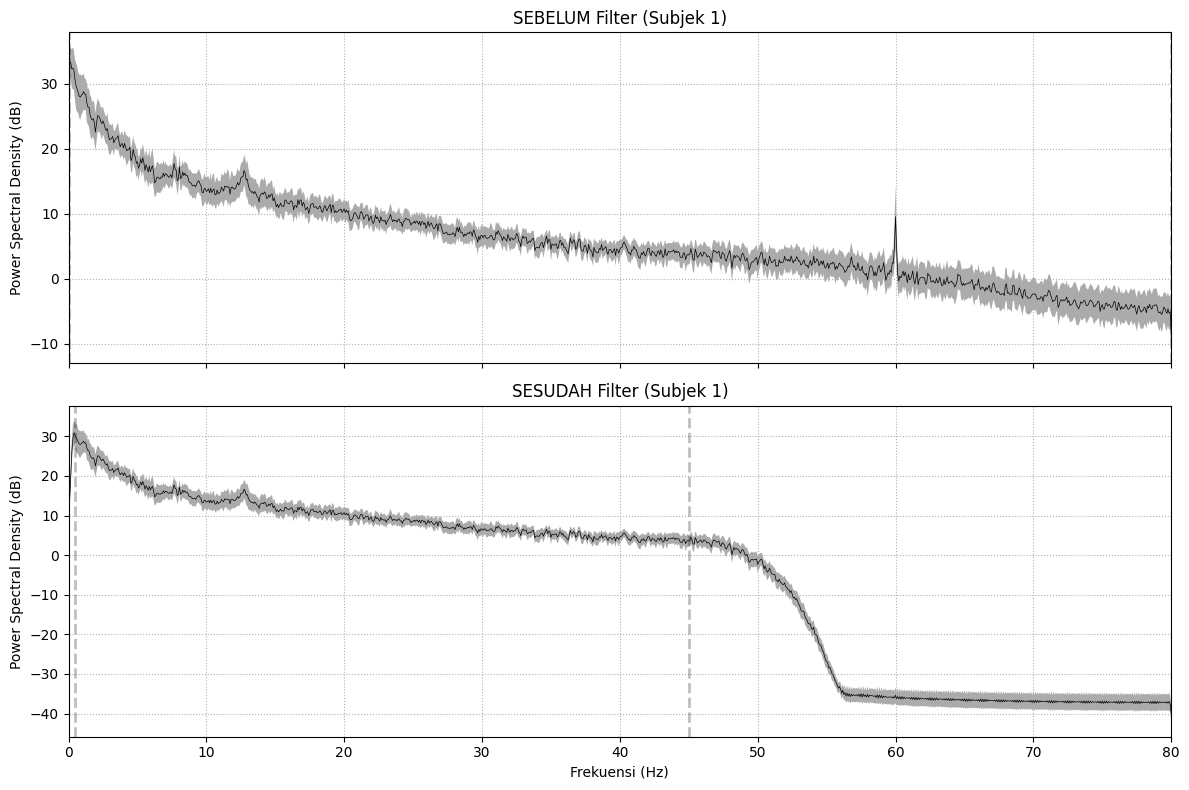

In [142]:
fnames_raw_sub1 = mne.datasets.eegbci.load_data(1, runs)
raw_sub1_unfiltered = mne.io.concatenate_raws(
    [mne.io.read_raw_edf(f, preload=True) for f in fnames_raw_sub1]
)

raw_sub1_filtered = all_raw_filtered[0]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

raw_sub1_unfiltered.plot_psd(ax=ax1, show=False, average=True)
ax1.set_title("SEBELUM Filter (Subjek 1)")
ax1.set_ylabel("Power Spectral Density (dB)")

raw_sub1_filtered.plot_psd(ax=ax2, show=False, average=True)
ax2.set_title("SESUDAH Filter (Subjek 1)")
ax2.set_xlabel("Frekuensi (Hz)")
ax2.set_ylabel("Power Spectral Density (dB)")

plt.tight_layout()
plt.show()

In [143]:
tmin = 0.0
tmax = 4.0

all_epochs = []

print("Parameter Epoching diatur.")
print(f"Jendela waktu (Window): {tmin}s hingga {tmax}s setelah event.")

Parameter Epoching diatur.
Jendela waktu (Window): 0.0s hingga 4.0s setelah event.


In [144]:

for sub_id_index, raw_filtered in enumerate(all_raw_filtered):
    print(f"Melakukan Epoching untuk Subjek {sub_id_index + 1}...")

    events, event_map = mne.events_from_annotations(raw_filtered)

    event_id = {
        'Tangan': event_map['T1'],
        'Kaki': event_map['T2']
    }

    epochs = mne.Epochs(
        raw_filtered,
        events=events,
        event_id=event_id,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        preload=True
    )

    all_epochs.append(epochs)

print("\n--- Selesai! ---")
print(f"Total {len(all_epochs)} data subjek telah di-epoching.")

Melakukan Epoching untuk Subjek 1...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped
Melakukan Epoching untuk Subjek 2...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped
Melakukan Epoching untuk Subjek 3...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped
Melakukan Epoching untuk Subjek 4...
Used Anno

In [145]:
epochs_sub1 = all_epochs[0]

print("\n--- Verifikasi Epochs (Subjek 1) ---")
print(epochs_sub1)


--- Verifikasi Epochs (Subjek 1) ---
<Epochs | 45 events (all good), 0 – 4 s (baseline off), ~14.1 MiB, data loaded,
 'Tangan': 23
 'Kaki': 22>


In [146]:
available_channels = epochs_sub1.info['ch_names']

print("--- 64 Channel yang Tersedia (Contoh 20 Pertama) ---")
print(available_channels[:20])
pick_channel = available_channels[0]
print(f"\nChannel yang dipilih untuk visualisasi: {pick_channel}")

--- 64 Channel yang Tersedia (Contoh 20 Pertama) ---
['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.']

Channel yang dipilih untuk visualisasi: Fc5.


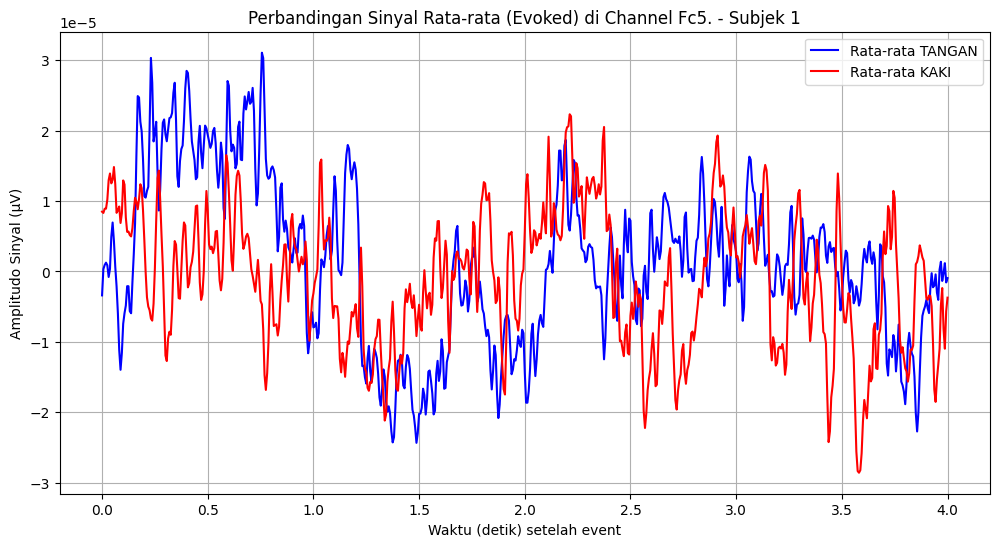

In [147]:
evoked_tangan = epochs_sub1['Tangan'].average(picks=pick_channel)
evoked_kaki = epochs_sub1['Kaki'].average(picks=pick_channel)

times = epochs_sub1.times

plt.figure(figsize=(12, 6))
plt.plot(times, evoked_tangan.data.T, label='Rata-rata TANGAN', color='blue')
plt.plot(times, evoked_kaki.data.T, label='Rata-rata KAKI', color='red')
plt.title(f'Perbandingan Sinyal Rata-rata (Evoked) di Channel {pick_channel} - Subjek 1')
plt.xlabel('Waktu (detik) setelah event')
plt.ylabel('Amplitudo Sinyal (µV)')
plt.legend()
plt.grid(True)
plt.show()

In [148]:
X_list = []
y_list = []

for epochs in all_epochs:
    X_list.append(epochs.get_data())
    y_list.append(epochs.events[:, 2])

X = np.vstack(X_list)
y = np.concatenate(y_list)

le = LabelEncoder()
y = le.fit_transform(y)

print(f"Data dari 15 subjek telah digabung.")
print(f"Bentuk (Shape) X (data): {X.shape}")
print(f"Bentuk (Shape) y (label): {y.shape}")

print(f"Label asli {le.classes_} telah diubah menjadi 0 dan 1.")

Data dari 15 subjek telah digabung.
Bentuk (Shape) X (data): (675, 64, 641)
Bentuk (Shape) y (label): (675,)
Label asli [2 3] telah diubah menjadi 0 dan 1.


In [149]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("--- Data Berhasil Dibagi ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

--- Data Berhasil Dibagi ---
X_train shape: (540, 64, 641)
y_train shape: (540,)
X_test shape: (135, 64, 641)
y_test shape: (135,)


In [150]:
scaler = StandardScaler()

n_trials_train, n_ch, n_times = X_train.shape
X_train_2d = X_train.reshape(n_trials_train, n_ch * n_times)

scaler.fit(X_train_2d)

X_train_norm_2d = scaler.transform(X_train_2d)

X_train_norm = X_train_norm_2d.reshape(n_trials_train, n_ch, n_times)

print("--- Training Set Telah Dinormalisasi ---")
print(f"Data diubah ke 2D: {X_train_2d.shape}")
print(f"Data dikembalikan ke 3D: {X_train_norm.shape}")

--- Training Set Telah Dinormalisasi ---
Data diubah ke 2D: (540, 41024)
Data dikembalikan ke 3D: (540, 64, 641)


In [151]:
n_trials_test, _, _ = X_test.shape
X_test_2d = X_test.reshape(n_trials_test, n_ch * n_times)

X_test_norm_2d = scaler.transform(X_test_2d)

X_test_norm = X_test_norm_2d.reshape(n_trials_test, n_ch, n_times)

print("\n--- Test Set Telah Dinormalisasi (Menggunakan Statistik Train Set) ---")
print(f"Data diubah ke 2D: {X_test_2d.shape}")
print(f"Data dikembalikan ke 3D: {X_test_norm.shape}")


--- Test Set Telah Dinormalisasi (Menggunakan Statistik Train Set) ---
Data diubah ke 2D: (135, 41024)
Data dikembalikan ke 3D: (135, 64, 641)


In [152]:
print("\n--- Verifikasi Hasil Normalisasi (Train Set) ---")
print(f"Mean (rata-rata) X_train_norm: {X_train_norm.mean():.4f}")
print(f"Std Dev (std) X_train_norm:   {X_train_norm.std():.4f}")

print(f"\nMean (rata-rata) X_test_norm: {X_test_norm.mean():.4f}")
print(f"Std Dev (std) X_test_norm:   {X_test_norm.std():.4f}")


--- Verifikasi Hasil Normalisasi (Train Set) ---
Mean (rata-rata) X_train_norm: -0.0000
Std Dev (std) X_train_norm:   1.0000

Mean (rata-rata) X_test_norm: -0.0158
Std Dev (std) X_test_norm:   1.0708


DL

In [153]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_norm, y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train
)

print("--- Data Berhasil Dibagi (Train/Validation/Test) ---")
print(f"X_train_final shape: {X_train_final.shape}")
print(f"y_train_final shape: {y_train_final.shape}")
print(f"X_val shape:     {X_val.shape}")
print(f"y_val shape:     {y_val.shape}")
print(f"X_test_norm shape: {X_test_norm.shape}")
print(f"y_test shape:    {y_test.shape}")

--- Data Berhasil Dibagi (Train/Validation/Test) ---
X_train_final shape: (405, 64, 641)
y_train_final shape: (405,)
X_val shape:     (135, 64, 641)
y_val shape:     (135,)
X_test_norm shape: (135, 64, 641)
y_test shape:    (135,)


In [154]:
n_ch = X_train_final.shape[1]
n_times = X_train_final.shape[2]

X_train_reshaped = X_train_final.reshape(X_train_final.shape[0], n_ch, n_times, 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], n_ch, n_times, 1)
X_test_reshaped = X_test_norm.reshape(X_test_norm.shape[0], n_ch, n_times, 1)

print("\n--- Data Siap untuk CNN ---")
print(f"Bentuk input baru: {X_train_reshaped.shape}")


--- Data Siap untuk CNN ---
Bentuk input baru: (405, 64, 641, 1)


In [165]:
model = Sequential()

model.add(Input(shape=(n_ch, n_times, 1)))

model.add(Conv2D(
    filters=16,
    kernel_size=(1, 32),
    activation='elu',
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    filters=16,
    kernel_size=(n_ch, 1),
    activation='elu',
    padding='valid'
))
model.add(BatchNormalization())

model.add(AveragePooling2D(pool_size=(1, 4)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(32, activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 64, 641, 16)    │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 641, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 1, 641, 16)     │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 1, 641, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 1, 160, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1, 160, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │        81,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,041 (386.88 KB)

 Trainable params: 98,977 (386.63 KB)

 Non-trainable params: 64 (256.00 B)

In [166]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [167]:
N_EPOCHS = 25
BATCH_SIZE = 32

print("\n--- Memulai Pelatihan Model ---")

history = model.fit(
    X_train_reshaped,
    y_train_final,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    validation_data=(X_val_reshaped, y_val)
)

print("--- Pelatihan Selesai ---")


--- Memulai Pelatihan Model ---
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step - accuracy: 0.5435 - loss: 1.1537 - val_accuracy: 0.6296 - val_loss: 0.6070
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6637 - loss: 0.7811 - val_accuracy: 0.6519 - val_loss: 0.6099
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7136 - loss: 0.6161 - val_accuracy: 0.6593 - val_loss: 0.6128
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7089 - loss: 0.6682 - val_accuracy: 0.6667 - val_loss: 0.6202
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8137 - loss: 0.5195 - val_accuracy: 0.6815 - val_loss: 0.6478
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8059 - loss: 0.4227 - val_accuracy: 0.6444 - val_loss: 0.6066
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8049 - loss: 0.5270 - val_accuracy: 0.6519 - val_loss: 0.6378
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8216 - loss:

eval


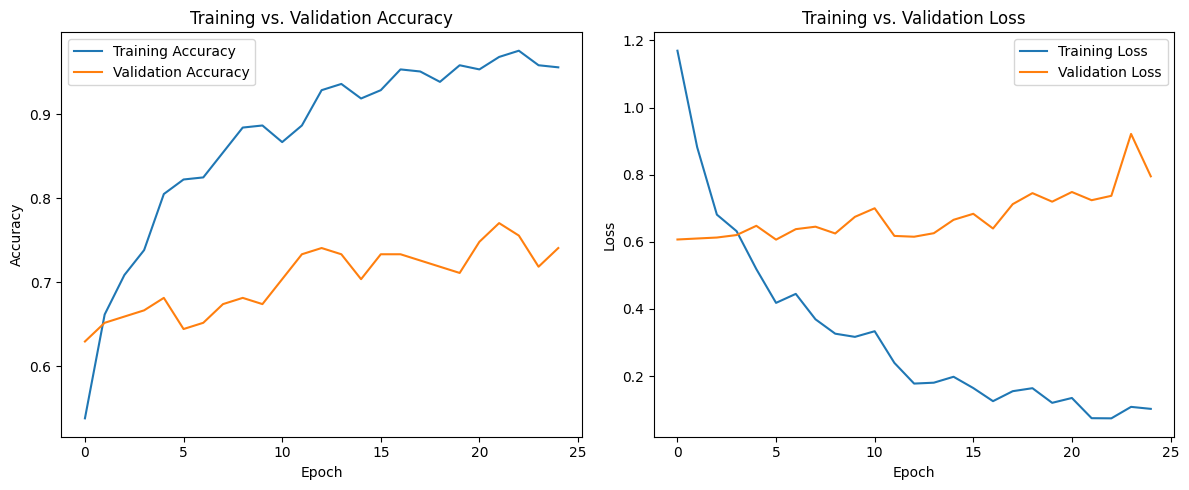

In [168]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step
--- Laporan Klasifikasi (Test Set) ---
              precision    recall  f1-score   support

  Tangan (0)       0.74      0.75      0.74        67
    Kaki (1)       0.75      0.74      0.74        68

    accuracy                           0.74       135
   macro avg       0.74      0.74      0.74       135
weighted avg       0.74      0.74      0.74       135


--- Confusion Matrix (Test Set) ---


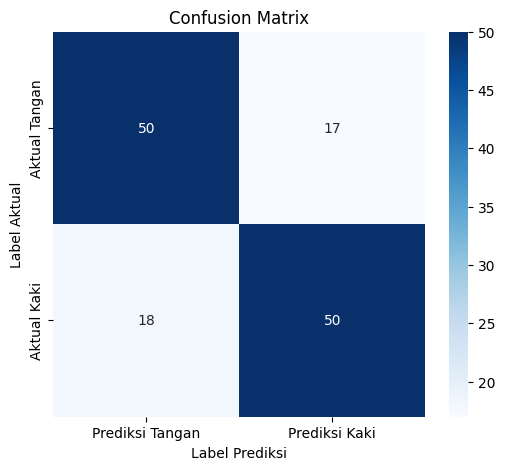

In [169]:
y_pred_proba = model.predict(X_test_reshaped)

y_pred = (y_pred_proba > 0.5).astype(int)

print("--- Laporan Klasifikasi (Test Set) ---")
print(classification_report(y_test, y_pred, target_names=['Tangan (0)', 'Kaki (1)']))

print("\n--- Confusion Matrix (Test Set) ---")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi Tangan', 'Prediksi Kaki'],
            yticklabels=['Aktual Tangan', 'Aktual Kaki'])
plt.title('Confusion Matrix')
plt.ylabel('Label Aktual')
plt.xlabel('Label Prediksi')
plt.show()